## Description and assumptions

Due to the time constrain I limit the scope to 1000 rows and uses the precomputed predictions. I also used a LLM from Azure Open AI, the GP4 model due to that is something I have used a lot lately. With GPT4 comes the benefit of less data engineering/cleaning compared to a model such as BART. It also does not need traning for this task. A downside of GPT4 compared to BART is the inference speed. 

I took the decision to use the BART output as ground truth for this exercise. However, I show that the BART model has obvius flaws as well. 

**Conclusion:**

GPT4 is more prone to use the label "positive". And introduces a new category, "neutral" for tweets that gets the exact score of 0.5. However, GPT4 is consistent in classifying postive/negative if score is higher/lower than 0.5, BART is not consistent.

When doing the occular investigation of 10 random rows, I argue for that GPT4 generalises better and classifies the tweets as I would do. 

BARTs obvius advantage is inference speed (especially with a GPU, which I don't have) and cost. 

## Imports

In [47]:
import os
import json
import pandas as pd
from openai import AzureOpenAI
import matplotlib.pyplot as plt
from sklearn import metrics

## Read the data 

In [2]:
# Set display options so you can see the full names of the column values
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

In [3]:
# read the csv file with pandas
twitter_df = pd.read_csv("data/twitter_dataset_small_w_bart_preds.csv")

In [4]:
# Only take the first 1000 rows, due to time constraints
twitter_df = twitter_df.head(1000)

In [5]:
twitter_df.head()

,is_positive,id,datetime,user,message,bart_is_positive
0,0,2200003313,Tue Jun 16 18:18:13 PDT 2009,DEWGetMeTho77,@Nkluvr4eva My poor little dumpling In Holmdel vids he was really trying...Hope he dont try to hard tonight xx,0.005163
1,0,1467998601,Mon Apr 06 23:11:18 PDT 2009,Young_J,I'm off too bed. I gotta wake up hella early tomorrow morning.,0.339430
2,0,2300049112,Tue Jun 23 13:40:12 PDT 2009,dougnawoschik,I havent been able to listen to it yet My speakers are busted,0.065703
3,0,1993474319,Mon Jun 01 10:26:09 PDT 2009,thireven,now remembers why solving a relatively big equation with two unknowns is a total pain in the butt,0.004046
4,0,2256551006,Sat Jun 20 12:56:51 PDT 2009,taracollins086,"Ate too much, feel sick",0.000581


In [6]:
# count the number of positive and negative tweets
# a negative tweet has is_positive = 0
# a positive tweet has is_positive = 1
twitter_df["is_positive"].value_counts()

is_positive
1    504
0    496
Name: count, dtype: int64

In [7]:
# check for any missing values in the datafame
twitter_df.isnull().sum()

is_positive         0
id                  0
datetime            0
user                0
message             0
bart_is_positive    0
dtype: int64

In [8]:
# drop columns id, datetime	and user
twitter_df.drop(columns=["id", "datetime", "user"], inplace=True)

I conclude that in general, under 0.5 is negative and over is positive

In [9]:
# Check what the boundaries are for the score
# How many tweets have a score under 0.5 and is classified as negative
twitter_df[(twitter_df["bart_is_positive"] < 0.5) & (twitter_df["is_positive"] == 0)].value_counts().sum()

448

In [10]:
twitter_df.head()

,is_positive,message,bart_is_positive
0,0,@Nkluvr4eva My poor little dumpling In Holmdel vids he was really trying...Hope he dont try to hard tonight xx,0.005163
1,0,I'm off too bed. I gotta wake up hella early tomorrow morning.,0.339430
2,0,I havent been able to listen to it yet My speakers are busted,0.065703
3,0,now remembers why solving a relatively big equation with two unknowns is a total pain in the butt,0.004046
4,0,"Ate too much, feel sick",0.000581


## Create a sentiment classifier with AzureOpenAI API

In [11]:
def classify_twitter_message_fn(
    user_message: str,
    system_message: str,
    temperature: int = 0,
    max_tokens: int = 100,
) -> dict:
    """
    Sentiment classification of twitter messages using Azure OpenAI.

    Args:
        user_message (str): The user message.
        system_message (str): The system message.
        temperature (int, optional): Controls the randomness of the output.
            Higher values make the output more random. Defaults to 0.
        max_tokens (int): The maximum number of tokens to generate.

    Returns:
        dict: The sentiment classification of the user message. Or an error message.
    """
    
    client = AzureOpenAI(
        azure_endpoint=os.getenv("AZURE_OPENAI_ENDPOINT"),
        api_version=os.getenv("AZURE_OPEN_AI_VERSION"),
        api_key=os.getenv("AZURE_OPENAI_API_KEY"),
    )          

    messages = [
        {'role': 'system', 'content': system_message},
        {'role': 'user', 'content': f"{user_message}"}
    ]

    try:

        completion = client.chat.completions.create(
        model=os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME"),
        messages=messages,
        temperature=temperature,
        max_tokens=max_tokens
        )

    except:
        return {"sentiment": "error", "score": "error"}

    try:
        json_response = json.loads(completion.choices[0].message.content)

        return json_response
    
    except json.JSONDecodeError:

        return {"sentiment": "error", "score": "error"}

I use the sentiment positive or negative, and then later convert it to a 1 or 0. I think this will give a better result than the model returning 1 or 0 directly.

In [12]:
system_message = """You are an helpful AI assistant. You help the user classify twitter messages to be either positive or negative.
You also output a score between 0.000000 and 1.000000, where 0 is negative and 1 is positive.

Here are a few examples of twitter messages and the sentiments and its scores:

Example 1,
user_message: "I love the new iPhone. It's the best phone ever!
sentiment: positive
score: 1.000000

Example 2,
user_message: "The new Fast and Furius movie is not good at all. Not worth the popcorn!
sentiment: negative
score: 0.210021

Example 3,
user_message: "That restaurnat with the big stone horse in Gothenburg is so so. The food is good but the service is bad.
sentiment: negative
score: 0.456210

Example 4,
user_message: "That bike is totally ok"
sentiment: positive
score: 0.605812

You must always output your answer in a JSON document with the following key-value pairs:
- "sentiment": the sentiment you classified for the twitter message, either positive or negative.
- "score": the score between 0.00 and 1.00. 

Output only the JSON document. Nothing else.

Without the Markdown code block formatting such as ```json```
"""

## Call the model

In [13]:
# Need to fill it due to intermediate data dumps
sentiment_lst = ["sentiment"] * len(twitter_df)
score_lst = ["score"] * len(twitter_df)

counter = 1

for i, row in twitter_df.iterrows():
    print(f"Classifying tweet number {counter}")
    user_message = row["message"]
    response = classify_twitter_message_fn(user_message, system_message)
    sentiment_lst[i] = response["sentiment"]
    score_lst[i] = response["score"]
    counter += 1

    if response["sentiment"] == "error":
        print("Error in the response. Check the response for more information.")

    # For every 100th row save the dataframe to a csv file as backup
    if counter % 100 == 0:

        twitter_df["sentiment"] = sentiment_lst
        twitter_df["score"] = score_lst

        twitter_df.to_csv(f"data/twitter_dataset_row_{counter}.csv", index=False)


twitter_df["sentiment"] = sentiment_lst
twitter_df["score"] = score_lst

twitter_df.to_csv("data/twitter_dataset_full_file.csv", index=False)



Classifying tweet number 1
Classifying tweet number 2
Classifying tweet number 3
Classifying tweet number 4
Classifying tweet number 5
Classifying tweet number 6
Classifying tweet number 7
Classifying tweet number 8
Classifying tweet number 9
Classifying tweet number 10
Classifying tweet number 11
Classifying tweet number 12
Classifying tweet number 13
Classifying tweet number 14
Classifying tweet number 15
Classifying tweet number 16
Classifying tweet number 17
Classifying tweet number 18
Classifying tweet number 19
Classifying tweet number 20
Classifying tweet number 21
Classifying tweet number 22
Classifying tweet number 23
Classifying tweet number 24
Classifying tweet number 25
Classifying tweet number 26
Classifying tweet number 27
Classifying tweet number 28
Classifying tweet number 29
Classifying tweet number 30
Classifying tweet number 31
Classifying tweet number 32
Classifying tweet number 33
Classifying tweet number 34
Classifying tweet number 35
Classifying tweet number 36
C

In [14]:
twitter_df.head(10)

,is_positive,message,bart_is_positive,sentiment,score
0,0,@Nkluvr4eva My poor little dumpling In Holmdel vids he was really trying...Hope he dont try to hard tonight xx,0.005163,negative,0.35
1,0,I'm off too bed. I gotta wake up hella early tomorrow morning.,0.339430,negative,0.35
2,0,I havent been able to listen to it yet My speakers are busted,0.065703,negative,0.3
3,0,now remembers why solving a relatively big equation with two unknowns is a total pain in the butt,0.004046,negative,0.2
4,0,"Ate too much, feel sick",0.000581,negative,0.2
5,0,Tried to purchase a parked domain through GoDaddy. $70 down the drain kind of like gambling...,0.001116,negative,0.2
6,1,on lunch....dj should come eat with me,0.657557,positive,0.7
7,0,Just got back from VA Tech Equine Medical Center...my poor Lilly has to be on stall rest for at least another month,0.017802,negative,0.3
8,0,can't log in to my other twitter account. super bummed,0.001638,negative,0.25
9,1,@TamaraSchilling Adventure - That's what we all need in our life. I am glad you had a great week. Thanks for yr response,0.897199,positive,0.89


## Evaluation

Prepare the data for visualization

In [35]:
# Read the full file
twitter_sentiment_scores_df = pd.read_csv("data/twitter_dataset_full_file.csv")

We can see that the model misclassifies 37 tweets as neutral and has 13 errors

In [36]:
twitter_sentiment_scores_df["sentiment"].value_counts()

sentiment
positive    537
negative    413
neutral      37
error        13
Name: count, dtype: int64

If we take a quick look at the neutral rows. We can see that they are hard to classify. I would say they are neutral tweets. But that was not the task of this exercise and is therefore an error.

In [37]:
# Select the rows where the sentiment is neutral
neutral_tweets = twitter_sentiment_scores_df[twitter_sentiment_scores_df["sentiment"] == "neutral"]

In [38]:
neutral_tweets.head(5)

,is_positive,message,bart_is_positive,sentiment,score
66,0,@IrieDiva can only make what the company has available,0.075359,neutral,0.5
91,1,@4prina can u check mine out and tell me wat u think www.myspace.com/trabeezy,0.094705,neutral,0.5
96,1,is on the phone,0.465470,neutral,0.5
111,0,Looks like I might be staying in tonight,0.479342,neutral,0.5
149,1,@sbhoools Get 100 followers a day using www.tweeterfollow.com Once you add everyone you are on the train or pay vip,0.145187,neutral,0.5


Convert the string values to integers in order to easier compare between the two models

In [44]:
# Change the values in the sentiment column to 0 for negative, 1 for positive and 2 for neutral
twitter_sentiment_scores_df["sentiment"] = twitter_sentiment_scores_df["sentiment"].replace({"negative": 0, "positive": 1, "neutral": 2, "error": 3})

/var/folders/x0/3tkfgj0n5sncvyjmxbtw_d9c0000gp/T/ipykernel_66177/2921037368.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  twitter_sentiment_scores_df["sentiment"] = twitter_sentiment_scores_df["sentiment"].replace({"negative": 0, "positive": 1, "neutral": 2, "error": 3})


In [46]:
twitter_sentiment_scores_df["sentiment"].value_counts()

sentiment
1    537
0    413
2     37
3     13
Name: count, dtype: int64

In [67]:
# Change the values in the score column which are "error" to 0
twitter_sentiment_scores_df["score"] = twitter_sentiment_scores_df["sentiment"].replace({"error": 0})

# convert the column "score" to float in order to be able to do comparision
twitter_sentiment_scores_df["score"] = twitter_sentiment_scores_df["score"].astype(float)

### Assuming BART model is the ground truth
(even if we see that both models has its pros and cons later in the evaluation)

#### Bar plot
In the barplot below can we see that the BART model has an even distribution between the two classes while GPT4 is tending to put a positive label more often.

<Axes: title={'center': 'sentiment GPT4'}, xlabel='sentiment'>

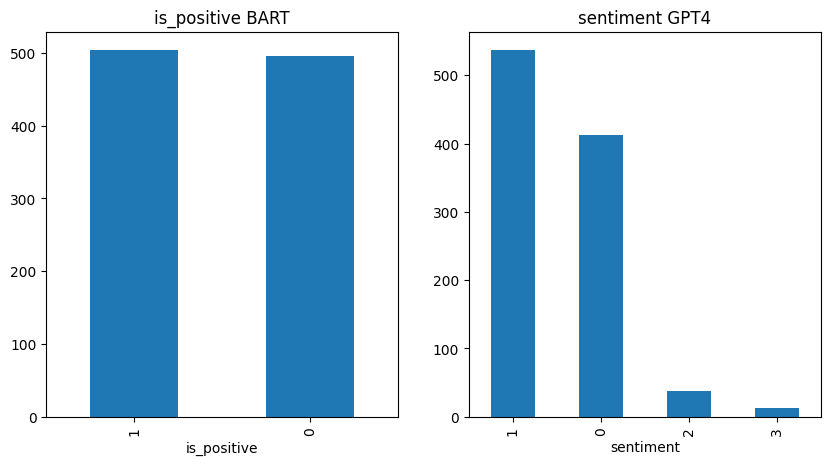

In [49]:
# create a bar plot of the two columns "is_positive" and "sentiment"
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
twitter_sentiment_scores_df["is_positive"].value_counts().plot(kind="bar", ax=ax[0], title="is_positive BART")
twitter_sentiment_scores_df["sentiment"].value_counts().plot(kind="bar", ax=ax[1], title="sentiment GPT4")

In [52]:
# Numbers to clarify the left plot
twitter_sentiment_scores_df["is_positive"].value_counts()

is_positive
1    504
0    496
Name: count, dtype: int64

In [51]:
# Numbers to clarify the right plot
twitter_sentiment_scores_df["sentiment"].value_counts()

sentiment
1    537
0    413
2     37
3     13
Name: count, dtype: int64

#### Calculate the accuracy

In 77% of the cases, the output of the models match

In [53]:
# Calculate the accuracy score
y_test = twitter_sentiment_scores_df["is_positive"] 
y_pred = twitter_sentiment_scores_df["sentiment"]

accuracy = metrics.accuracy_score(y_test, y_pred)

print("Accuracy: ", accuracy)

Accuracy:  0.773


#### Calculate a confusion matrix

The predictions differs quite a lot between the models. We can see how the GPT4 model tend to use the positive label more, hence more FP (122).

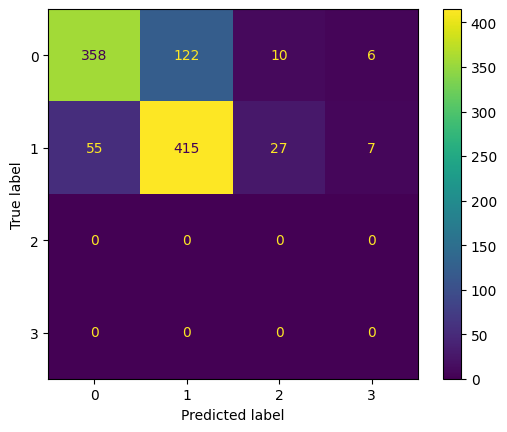

In [55]:
confusion_matrix = metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1, 2, 3])

cm_display.plot()
plt.show()

### Compare score and sentiment
I want to make sure both models are consistent in putting the right label for above/over 0.5. 

We can see that GPT4 is consistent with classifications of negative/positive sentiments if the score is under/over 0.5. BART is not as accurate.

#### Check how many of the positive tweets has a score less than 0.5

In [75]:
# BART model
twitter_df[(twitter_df["bart_is_positive"] < 0.5) & (twitter_sentiment_scores_df["is_positive"] == 1)].value_counts().sum()

252

In [76]:
# GPT4 model
twitter_sentiment_scores_df[(twitter_sentiment_scores_df["score"] < 0.5) & (twitter_sentiment_scores_df["sentiment"] == 1)].value_counts().sum()

0

#### Check how many of the negative tweets has a score more than 0.5

In [77]:
# BART model
twitter_df[(twitter_df["bart_is_positive"] > 0.5) & (twitter_sentiment_scores_df["is_positive"] == 0)].value_counts().sum()

48

In [78]:
# GPT4 model
twitter_sentiment_scores_df[(twitter_sentiment_scores_df["score"] > 0.5) & (twitter_sentiment_scores_df["sentiment"] == 0)].value_counts().sum()

0

#### Sampling of positive, negative and neutral sentiment
This project does not have a real ground truth, hence random sampling and looking at the result make sence.

Some comments for some rows that stood out.

- Row 593: I think GPT4 does a better job here and classifies positive and with a high score.

- Row 452: BART is classifying this row as very positve for some reason. Probably due to "new" is part of many positive comments/text in the training set.

- Row 607: Big discrepnce between the two models. Both is classifying it as positive but BART is giving it a low bart_is_positive

In [69]:
# Compare 10 random tweets
random_sample_df = twitter_df.sample(10)

# Reorganize the columns
random_sample_df = random_sample_df[["message", "bart_is_positive", "is_positive", "score", "sentiment"]]

In [70]:
random_sample_df

,message,bart_is_positive,is_positive,score,sentiment
593,@Silveysurfer they also removed the family photos &amp; story from the menu. I loved that part! Still WAY better than Knoxville Italian.,0.624125,0,0.75,1
373,@glamourdolleyes We have one - it is out of stock,0.055182,0,0.35,0
736,@shabzcohelp can I have it,0.652079,1,0.6,1
932,"@eyesystem Bonjour, you said @Kaphoen please explain - but I'm not sure to what...",0.017493,1,0.5,1
535,@beardandbeers I forgot my jacket at the Barbary last night. I suck.,0.008813,0,0.25,0
583,Its damn hot in our classroom,0.004367,0,0.35,0
452,new new new,0.948048,1,0.6,1
607,who wants there photo taken today and i mean b4 the beautiful sun fades away? any takers holla asap im am so freakin bored,0.033565,1,0.75,1
169,&quot;Thank You [Lord] for reminding me to see myself the way You see me!&quot;,0.822485,1,0.95,1
385,@MadisonCreek Thanks...yea I've known her since she was like 7...great kid...like another niece to me.,0.819989,1,0.85,1


In [6]:
import pandas as pd

df = pd.read_csv("data/twitter_dataset_full_file.csv")

df.loc[~df["sentiment"].isin(["positive", "negative"]),]

,is_positive,message,bart_is_positive,sentiment,score
62,1,@TheUncoolest,0.000882,error,error
66,0,@IrieDiva can only make what the company has a...,0.075359,neutral,0.5
91,1,@4prina can u check mine out and tell me wat u...,0.094705,neutral,0.5
96,1,is on the phone,0.465470,neutral,0.5
111,0,Looks like I might be staying in tonight,0.479342,neutral,0.5
149,1,@sbhoools Get 100 followers a day using www.tw...,0.145187,neutral,0.5
194,1,@RobbieTaylor I have no comment about who won ...,0.089209,neutral,0.5
195,1,is in trevs room; about to do bon qui qui,0.926522,neutral,0.5
199,1,Downtown Disney,0.751881,neutral,0.5
211,0,@lrpw1302 Im covered in the bloody stuff. Cant...,0.003649,error,error
